In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
!pip install transformers==3.3.1
from transformers import AutoModel, AutoTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 1.1MB 5.2MB/s 
     |████████████████████████████████| 890kB 35.4MB/s 
     |████████████████████████████████| 1.2MB 35.0MB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=17f74d91e657ba036a596979df7e8405189bfd33a8a79934a33e34190608a6b8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mal_full_offensive_train.csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
# train['label'].value_counts()
# train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
train.head(9)

,text,label
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,Not_offensive
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,Not_offensive
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,Not_offensive
3,Sushin syam Shaiju khalid Midhun manual,Not_offensive
4,J A K E S. B EJ O Y !!!,Not_offensive
5,Pwoli item padam kananda ennu karuthiyatha pak...,Not_offensive
6,Oru ratchasan feel kittitu ullalo. Bgm athra a...,Not_offensive
7,Super casting,Not_offensive
8,ഷൈലോക്ക് ന്റെ നല്ല ടീസർ ആയിട്ട് പോലും ട്രോളി ന...,Not_offensive


In [4]:
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
train.head(9)

,text,label
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,0
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,0
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,0
3,Sushin syam Shaiju khalid Midhun manual,0
4,J A K E S. B EJ O Y !!!,0
5,Pwoli item padam kananda ennu karuthiyatha pak...,0
6,Oru ratchasan feel kittitu ullalo. Bgm athra a...,0
7,Super casting,0
8,ഷൈലോക്ക് ന്റെ നല്ല ടീസർ ആയിട്ട് പോലും ട്രോളി ന...,0


In [5]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mal_full_offensive_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.head(9)

,text,label
0,Gopichettante BGM um mammookayum ishtapedunnav...,Not_offensive
1,ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത് p...,Not_offensive
2,പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ്.. Lal jr. ന...,Not_offensive
3,പോകരുത് മക്കളെ പോക്ക .......... നൻ കണ്ട് എന്റ്...,Not_offensive
4,avan Varum ente Makan Madhura Raja....,Not_offensive
5,you guys dub in kannada we are kannadigas alwa...,not-malayalam
6,Oru nalla cinema kkaayi kathirikkkunnu. Dha...,Not_offensive
7,Nine film arkum venda,Not_offensive
8,ഭവനേ. കൊലേ കാട്ടിലേ ഇരിക്ക് കൊല്ലാമ വിടമാട്ടെ ...,Not_offensive


In [6]:
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
val.head(9)

,text,label
0,Gopichettante BGM um mammookayum ishtapedunnav...,0
1,ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത് p...,0
2,പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ്.. Lal jr. ന...,0
3,പോകരുത് മക്കളെ പോക്ക .......... നൻ കണ്ട് എന്റ്...,0
4,avan Varum ente Makan Madhura Raja....,0
5,you guys dub in kannada we are kannadigas alwa...,4
6,Oru nalla cinema kkaayi kathirikkkunnu. Dha...,0
7,Nine film arkum venda,0
8,ഭവനേ. കൊലേ കാട്ടിലേ ഇരിക്ക് കൊല്ലാമ വിടമാട്ടെ ...,0


In [7]:
test = pd.read_csv('/content/drive/MyDrive/test_labels/mal_full_offensive_test_with_labels.csv', delimiter='\t', names=['text','label','nan'])
test = test.drop(columns=['nan'])
test.head(9)

,text,label
0,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...,Not_offensive
1,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,Not_offensive
2,Fefka ee padam release cheyyan samadhicho?,Not_offensive
3,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,Not_offensive
4,Ravile thane views likes ethra ayyi enn nokan ...,Not_offensive
5,2.10- joju ചേട്ടന്റെ ആ ഇരുത്തം കണ്ടിട്ട് കിരീട...,Not_offensive
6,Engane aada uvve 32K dislikes okke vanne? namm...,Not_offensive
7,പടം കാണാത്തവരുണ്ടങ്കിൽ ഇന്ന് തന്നെ പോയി കണ്ടോ ...,Not_offensive
8,Enta joju etta ningalithe ende bhavichaa,Not_offensive


In [30]:
test.label = test.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
test.head(9)

,text,label
0,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ suraj ആണ് നടൻ ന്ന...,0
1,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,0
2,fefka ee padam release cheyyan samadhicho?,0
3,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,0
4,ravile thane views likes ethra ayyi enn nokan ...,0
5,. joju ചേട്ടന്റെ ആ ഇരുത്തം കണ്ടിട്ട് കിരീടം ട...,0
6,engane aada uvve k dislikes okke vanne? nammud...,0
7,പടം കാണാത്തവരുണ്ടങ്കിൽ ഇന്ന് തന്നെ പോയി കണ്ടോ ...,0
8,enta joju etta ningalithe ende bhavichaa,0


In [8]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
# clean(test)

In [31]:
clean(test)

In [9]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [10]:
print('Training set size:',train.shape)
# print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16010, 2)
Testing set size: (2001, 2)
validation set size: (1999, 2)


In [32]:
print('Testing set size:',test.shape)

Testing set size: (2001, 2)


In [11]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=4)

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [13]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
# test_data_loader = create_data_loader(test,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)

In [14]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return nn.functional.softmax(self.out(output))

In [16]:
model = RFClassifier(5,'bert-base-multilingual-cased')
model = model.to(device)

In [17]:
from transformers import AdamW,get_linear_schedule_with_warmup
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01 | Epoch Time: 11m 18s
Train Loss 1.0207514699823603 accuracy 0.8840099937539038
Val Loss 1.014531621857295 accuracy 0.889944972486243

Epoch: 02 | Epoch Time: 11m 17s
Train Loss 1.0208527137657364 accuracy 0.8840099937539038
Val Loss 1.0162142174584525 accuracy 0.889944972486243

Epoch: 03 | Epoch Time: 11m 17s
Train Loss 1.02083728591839 accuracy 0.8840099937539038
Val Loss 1.0156505637698703 accuracy 0.889944972486243

Epoch: 04 | Epoch Time: 11m 17s
Train Loss 1.0209691815985416 accuracy 0.8840099937539038
Val Loss 1.0156497416042147 accuracy 0.889944972486243

Epoch: 05 | Epoch Time: 11m 18s
Train Loss 1.0206958553986158 accuracy 0.8840099937539038
Val Loss 1.0156497416042147 accuracy 0.889944972486243



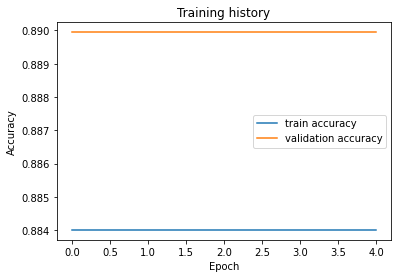

In [23]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1])

In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [33]:
test_data_loader = create_data_loader(test,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [35]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-malayalam' ]

In [36]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.88      1.00      0.94      1765
               Offensive_Untargetede       0.00      0.00      0.00        29
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        23
Offensive_Targeted_Insult_Individual       0.00      0.00      0.00        27
                       not-malayalam       0.00      0.00      0.00       157

                            accuracy                           0.88      2001
                           macro avg       0.18      0.20      0.19      2001
                        weighted avg       0.78      0.88      0.83      2001

